<a href="https://colab.research.google.com/github/handsomeboyck/colab_copy/blob/master/%E5%8D%8E%E4%B8%BA%E6%8E%A8%E8%8D%90_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于多目标优化的视频推荐

## 赛题简介

推荐系统大多都是基于隐式反馈来做推荐，比如用户的点击、观看时长、评论、分享等，且不同隐式反馈表达了用户不同的喜好程度。如果仅仅以单目标对推荐结果进行衡量，会存在衡量不全面的问题。如视频场景，假设某个用户打开一个视频看了开头觉得不喜欢立马关掉，如果以点击为目标则体现的是用户感兴趣，但实际情况是用户对这个视频不感兴趣。从这个例子可以看出，在视频推荐中如果仅仅以点击为目标，可能忽视了用户更深层次的隐式反馈。因此，视频推荐除了关注用户点击，还需关注用户观看时长、分享等目标，期望通过多目标能更深入地挖掘用户兴趣，做更精准的推荐。

https://developer.huawei.com/consumer/cn/activity/devStarAI/algo/competition.html#/preliminary/info/006/introduction

## 赛题说明

本赛题提供14天数据用于训练，1天数据用于测试，数据包括用户特征，视频内容特征，以及用户历史行为数据，选手基于给出的数据，提供推荐策略，目标是预测每位用户观看视频时长所在区间，且预测是否对视频进行分享。所提供的数据经过脱敏处理，保证数据安全。

## 赛题类型

- 评价指标：AUC加权和
- 赛题类型：用户留存预测，结构化数据

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/MyWorkPlace/3 /content/

## 赛题数据

https://digix-algo-challenge.obs.cn-east-2.myhuaweicloud.com/2021/AI/4d83d37a6bc6e83d0da3af019c18775c/2021_3_data.zip

提供的数据包括用户维度、视频维度以及用户历史行为数据，以下按照这三个维度分别说明。


### 用户特征

| 字段名称 | 说明 | 是否为空 | 类型 | 取值样例 |
| :------- | :--- | :------- | :--- | :------- |
| user_id     | 用户ID   | 否   | string | 1    |
| age         | 年龄段   | 是   | string | 0    |
| gender      | 性别     | 是   | string | 1    |
| country     | 国家     | 是   | string | 0    |
| province    | 所在省份 | 是   | string | 0    |
| city        | 所在城市 | 是   | string | 0    |
| city_level  | 城市级别 | 是   | string | 0    |
| device_name | 设备类型 | 是   | string | 0    |


### 视频内容特征

| 字段名称 | 说明 | 是否为空 | 类型 | 取值样例 |
| :------- | :--- | :------- | :--- | :------- |
| video_id            | 视频ID           | 否   | string | 16451                                                        |
| video_name          | 视频名称         | 是   | string | 天下无贼                                                     |
| video_tags          | 视频标签         | 是   | string | 扒手,反扒,t,tx,txm,txmz,txw,txwz,天下无贼,刘德华,刘若英,王宝强,冯小刚,张晞临,芒果TV,院线,剧情,李冰冰,葛优,动作,犯罪 |
| video_description   | 视频描述         | 是   | string | 王薄（刘德华 饰）和王丽（刘若英 饰）本是一对最佳贼拍档，但因怀了王薄的孩子，王丽决定收手赎罪，两人产生分歧。在火车站遇到刚刚从城市里挣了一笔钱准备回老家用它盖房子娶媳妇的农村娃子傻根（王宝强 饰）后，王丽被他的单纯打动，决定暗中保护不使他的辛苦钱失窃，王薄却寻思找合适机会下手，但 最终因为“夫妻情深”归入了王丽的阵营。 不料傻根的钱早被以黎叔（葛优 饰）为头目的另一著名扒窃团伙盯上，于是一系列围绕傻根书包里的钞票、在王薄、王丽和黎叔团伙之间展开的强强斗争上演。 |
| video_release_date  | 年代             | 是   | string | 2004/12/9                                                    |
| video_director_list | 导演名称         | 是   | string | 冯小刚,林黎胜                                                |
| video_actor_list    | 演员名称         | 是   | string | 刘德华,葛优,刘若英,王宝强                                    |
| video_score         | 评分             | 是   | string | 8.5                                                          |
| video_second_class  | 视频二级分类名称 | 是   | string | 喜剧,剧情,警匪,动作,犯罪                                     |
| video_duration      | 视频时长，单位秒 | 是   | string | 7246                                                         |

### 用户历史行为

| 字段名称 | 说明 | 是否为空 | 类型 | 取值样例 |
| :------- | :--- | :------- | :--- | :------- |
| user_id          | 用户id             | 否   | string | 1         |
| video_id         | 视频id             | 否   | string | 16451     |
| is_watch         | 是否播放           | 是   | int    | 1         |
| is_share         | 是否分享           | 是   | int    | 0         |
| is_collect       | 是否收藏           | 是   | int    | 0         |
| is_comment       | 是否评论           | 是   | int    | 0         |
| watch_start_time | 观看时间           | 是   | string | 2020-11-3 |
| watch_label      | 播放标签           | 是   | int    | 8         |
| pt_d             | 时间，用于数据分区 | 是   | string | 20201103  |


In [ ]:
ls

3/  drive/  sample_data/


## 评估方式

预测每位用户对视频观看时长所在区间，且预测是否对视频进行分享。本次比赛使用 AUC（ROC曲线下面积）作为评估指标，AUC 越高，代表结果越优，排名越靠前。各指标的AUC采用加权求和。

$$score = α*(0.1*AUC_{watch1}+ 0.2*AUC_{watch2}+0.3*AUC_{watch3}+0.4*AUC_{watch4}+0.5*AUC_{watch5}+0.6*AUC_{watch6}+0.7*AUC_{watch7} +0.8*AUC_{watch8} +0.9*AUC_{watch9} )+β*AUC_{share}$$

初赛：α为0.7，β为0.3

其中：视频观看时长、label、加权权重的对应关系如下。

| 观看时长区间【左闭右开区间】 | watch_label | 加权权重 |
| :--------------------------- | :---------- | :------- |
| 0~10%总片长    | 0    | 0    |
| 10~20%总片长   | 1    | 0.1  |
| 20%~30%总片长  | 2    | 0.2  |
| 30%~40%总片长  | 3    | 0.3  |
| 40%~50%总片长  | 4    | 0.4  |
| 50%~60%总片长  | 5    | 0.5  |
| 60%~70%总片长  | 6    | 0.6  |
| 70%~80%总片长  | 7    | 0.7  |
| 80%~90%总片长  | 8    | 0.8  |
| 90%~100%总片长 | 9    | 0.9  |

## 提交方式

选手提交结果为一个submission.csv 文件, 编码采用无BOM 的UTF-8，格式如下：user_id, video_id, watch_label, is_share。

其中user_id对应测试样本中的user_id，video_id对应测试样本的video_id，watch_label表示user_id观看video_id时长所在的时长区间，is_share表示用户是否对该视频进行了分享。user_id，video_id，watch_label，is_share间采用逗号分隔。

提交文件格式参考如下示例：

| user_id | video_id | watch_label | is_share |
| :------ | :------- | :---------- | :------- |
| 1    | 1    | 6    | 0    |
| 1    | 1    | 9    | 1    |
| ...  | ...  | ...  | ...  |

In [ ]:
!ls 3/*/* --full-time -Ggh

-rw-------  1  40M 2021-08-16 08:30:46.068289011 +0000 3/testdata/test.csv

3/traindata/history_behavior_data:
total 56K
drwx------ 2 4.0K 2021-08-16 08:31:31.686210298 +0000 20210419
drwx------ 2 4.0K 2021-08-16 08:31:36.891201324 +0000 20210420
drwx------ 2 4.0K 2021-08-16 08:31:26.313219563 +0000 20210421
drwx------ 2 4.0K 2021-08-16 08:31:42.117192315 +0000 20210422
drwx------ 2 4.0K 2021-08-16 08:31:15.463238272 +0000 20210423
drwx------ 2 4.0K 2021-08-16 08:31:05.764254996 +0000 20210424
drwx------ 2 4.0K 2021-08-16 08:31:19.797230798 +0000 20210425
drwx------ 2 4.0K 2021-08-16 08:30:57.473269291 +0000 20210426
drwx------ 2 4.0K 2021-08-16 08:31:03.038259695 +0000 20210427
drwx------ 2 4.0K 2021-08-16 08:31:09.185249097 +0000 20210428
drwx------ 2 4.0K 2021-08-16 08:31:00.134264703 +0000 20210429
drwx------ 2 4.0K 2021-08-16 08:30:54.514274407 +0000 20210430
drwx------ 2 4.0K 2021-08-16 08:31:12.382243584 +0000 20210501
drwx------ 2 4.0K 2021-08-16 08:30:51.107280298 +0000 202105

In [ ]:
!ls 3/traindata/history_behavior_data/20210419/

part-00000-236b99d5-456a-42b2-bd8d-3cbd61d21cc6-c000.csv


# 数据读取

In [ ]:
import pandas as pd
import glob, gc

%pylab inline
import seaborn as sns

INPUT_PATH = './3'
# 对数据类型进行转换,减小内存消耗
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

test_data = pd.read_csv(f'{INPUT_PATH}/testdata/test.csv', sep=',')
user_features = pd.read_csv(f'{INPUT_PATH}/traindata/user_features_data/user_features_data.csv', sep='\t')
video_features = pd.read_csv(f'{INPUT_PATH}/traindata/video_features_data/video_features_data.csv', sep='\t')
history_behavior = pd.concat([
    reduce_mem(pd.read_csv(x, sep='\t')) for x in glob.glob(f'{INPUT_PATH}/traindata/history_behavior_data/*/*')
])
history_behavior = history_behavior.sort_values(by=['pt_d', 'user_id'])

test_data = reduce_mem(test_data)
user_features = reduce_mem(user_features)
video_features = reduce_mem(video_features)
history_behavior = reduce_mem(history_behavior)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


368.09 Mb, 127.81 Mb (65.28 %)
383.36 Mb, 133.11 Mb (65.28 %)
448.31 Mb, 155.66 Mb (65.28 %)
374.51 Mb, 130.04 Mb (65.28 %)
397.30 Mb, 137.95 Mb (65.28 %)
444.39 Mb, 154.30 Mb (65.28 %)
437.46 Mb, 151.90 Mb (65.28 %)
379.69 Mb, 131.84 Mb (65.28 %)
347.10 Mb, 120.52 Mb (65.28 %)
378.43 Mb, 131.40 Mb (65.28 %)
387.82 Mb, 134.66 Mb (65.28 %)
372.54 Mb, 129.35 Mb (65.28 %)
388.03 Mb, 134.73 Mb (65.28 %)
405.14 Mb, 140.67 Mb (65.28 %)
43.06 Mb, 21.53 Mb (50.00 %)
360.77 Mb, 73.28 Mb (79.69 %)
3.79 Mb, 3.04 Mb (20.00 %)
2526.41 Mb, 2526.41 Mb (0.00 %)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r /content/drive/MyDrive/MyWorkPlace/3 /content/

In [ ]:
user_features.head() #用户特征

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [ ]:
video_features.head() #视频特征

,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.398438,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.601562,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800781,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.699219,"剧情,歌舞,喜剧",10608


In [ ]:
history_behavior.head() #历史行为特征

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_start_time,watch_label,pt_d
3275583,2,22485,1,0,0,0,2021-04-19,3,20210419
3275584,2,25469,1,0,0,0,2021-04-18,3,20210419
5391986,2,28411,0,0,0,0,NaN,0,20210419
5391987,2,49484,0,0,0,0,NaN,0,20210419
5391988,2,7069,0,0,0,0,NaN,0,20210419


# 数据分析

## 用户特征

In [ ]:
user_features.dtypes #用户特征类型

user_id        int32
age             int8
gender          int8
country         int8
province        int8
city           int16
city_level      int8
device_name    int16
dtype: object

In [ ]:
user_features.head() 

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [ ]:
for col in user_features.columns: 
    print(user_features.shape, user_features[col].nunique())  #查看每列的形状,得到具体的有多少类

(5910800, 8) 5910800
(5910800, 8) 8
(5910800, 8) 4
(5910800, 8) 3
(5910800, 8) 33
(5910800, 8) 339
(5910800, 8) 8
(5910800, 8) 1826


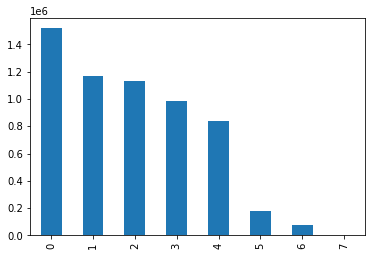

In [ ]:
user_features['age'].value_counts().plot(kind='bar')  # 用户年龄分布

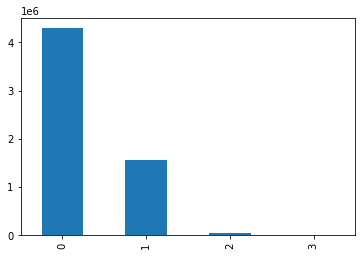

In [ ]:
user_features['gender'].value_counts().plot(kind='bar') # 用户性别分布

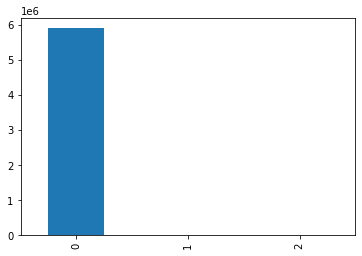

In [ ]:
user_features['country'].value_counts().plot(kind='bar') # 用户国家分布，可以看出分布十分不均匀，因此该特征可以丢弃

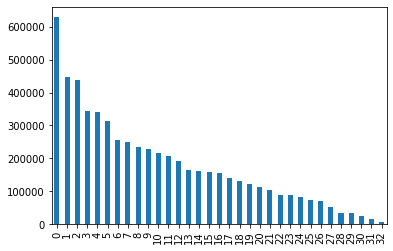

In [ ]:
user_features['province'].value_counts().plot(kind='bar') # 省份分布

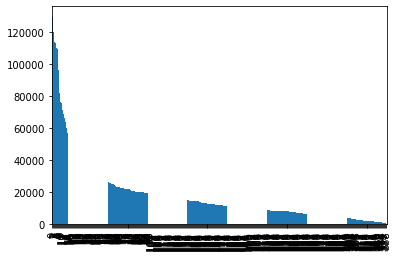

In [ ]:
user_features['city'].value_counts().plot(kind='bar') # 城市分布

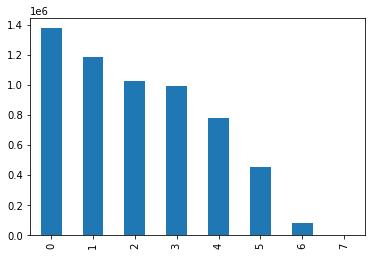

In [ ]:
user_features['city_level'].value_counts().plot(kind='bar') # 城市级别分布

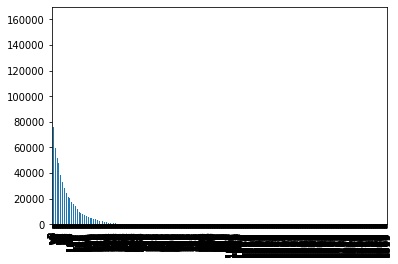

In [ ]:
user_features['device_name'].value_counts().plot(kind='bar') #设备分布

## 视频特征

In [ ]:
video_features.head() 

,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.398438,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.601562,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800781,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.699219,"剧情,歌舞,喜剧",10608


## 用户行为

In [ ]:
for col in history_behavior.columns: 
    print(history_behavior.shape, history_behavior[col].nunique()) # 查看用户行为特征每列的形状

(80276856, 9) 3953209
(80276856, 9) 34218
(80276856, 9) 2
(80276856, 9) 2
(80276856, 9) 2
(80276856, 9) 2
(80276856, 9) 91
(80276856, 9) 10
(80276856, 9) 14


In [ ]:
len(set(test_data['user_id']) & set(history_behavior['user_id'])) # 测试集里有用户行为的用户数量

422143

In [ ]:
test_data['user_id'].nunique() #用户总数

492174

In [ ]:
history_behavior = history_behavior[history_behavior['user_id'].isin(test_data['user_id'].unique())] 
val_behavior = history_behavior[history_behavior['pt_d'] == 20210502]
train_behavior = history_behavior[history_behavior['pt_d'] != 20210502]

val_behavior = val_behavior.rename(columns={"watch_label": "val_watch", "is_share": "val_share"})

In [ ]:
train_behavior = pd.merge(train_behavior, 
                          val_behavior[['user_id', 'video_id', 'val_watch', 'val_share']], 
                          on=['user_id', 'video_id'], how='left')

train_behavior['val_watch'] = train_behavior['val_watch'].fillna(0)
train_behavior['val_share'] = train_behavior['val_share'].fillna(0)

train_behavior = pd.concat([
    train_behavior[train_behavior['val_watch'] == 0].sample(50000),
    train_behavior[train_behavior['val_watch'] != 0]
])

In [ ]:
train_behavior['val_watch'].value_counts()
print(train_behavior)

          user_id  video_id  is_watch  ...      pt_d  val_watch  val_share
15316196  1606450     11992         1  ...  20210430        0.0        0.0
10458289  5823110     10094         0  ...  20210426        0.0        0.0
5107450    405343     44786         0  ...  20210423        0.0        0.0
361761    1714304     40847         0  ...  20210419        0.0        0.0
9659061   2392793     17724         0  ...  20210426        0.0        0.0
...           ...       ...       ...  ...       ...        ...        ...
18429157  5908762     41270         1  ...  20210501        1.0        0.0
18429467  5910109      3636         0  ...  20210501        6.0        0.0
18429475  5910163     44324         1  ...  20210501        9.0        0.0
18429598  5910390     46900         1  ...  20210501        6.0        0.0
18429607  5910413     49471         0  ...  20210501        9.0        0.0

[83339 rows x 11 columns]


In [ ]:
train_user_behavior_agg = train_behavior.groupby('user_id').agg({
    'pt_d': ['count'],
    'video_id': ['nunique'],
    'is_watch': ['mean', 'max'],
    'is_share': ['mean', 'max'],
    'watch_label': ['nunique']
})

In [ ]:
train_user_behavior_agg.columns = pd.Index([e[0] + "_" + e[1].upper() 
                for e in train_user_behavior_agg.columns.tolist()])
train_user_behavior_agg = train_user_behavior_agg.reset_index()

In [ ]:
print(train_user_behavior_agg)

       user_id  pt_d_COUNT  ...  is_share_MAX  watch_label_NUNIQUE
0          115           4  ...             0                    1
1          131           2  ...             0                    1
2          374           1  ...             0                    1
3          596           1  ...             0                    1
4          940           1  ...             0                    1
...        ...         ...  ...           ...                  ...
52582  5910413           2  ...             0                    1
52583  5910423           3  ...             0                    1
52584  5910604           2  ...             0                    1
52585  5910713           2  ...             0                    1
52586  5910778           1  ...             0                    1

[52587 rows x 8 columns]


In [ ]:
history_behavior[(history_behavior['user_id'] == 2) &
               (history_behavior['video_id'] == 25469)]

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_start_time,watch_label,pt_d
3275584,2,25469,1,0,0,0,2021-04-18,3,20210419
5290331,2,25469,0,0,0,0,NaN,0,20210421
2993539,2,25469,0,0,0,0,NaN,0,20210502


In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

class MLP(nn.Module):

    def __init__(self, n_users=5910794, n_items=50352, layers=[64, 32], dropout=False):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(n_users, 32)
        self.video_embedding = torch.nn.Embedding(n_items, 32)

        # list of weight matrices
        self.fc_layers = torch.nn.ModuleList()
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        self.output_layer1 = torch.nn.Linear(layers[-1], 10)
        self.output_layer2 = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        print(users)
        items = feed_dict['video_id']
        print(items)
        
        user_embedding = self.user_embedding(users)
        
        print(user_embedding)
        video_embedding = self.video_embedding(items)
       
        print(video_embedding)
        
        x = torch.cat([user_embedding, video_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x)
        logit1 = self.output_layer1(x)
        logit2 = self.output_layer2(x)
        return logit1, logit2

    def predict(self, feed_dict):
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = torch.from_numpy(
                    feed_dict[key]).to(dtype=torch.long, device='cpu')
        output_scores = self.forward(feed_dict)
        return output_scores

In [ ]:
import numpy as np
model = MLP()
print(model)
model.predict({'user_id':np.array([10, 10]), 'video_id':np.array([10, 10])})

MLP(
  (user_embedding): Embedding(5910794, 32)
  (video_embedding): Embedding(50352, 32)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer1): Linear(in_features=32, out_features=10, bias=True)
  (output_layer2): Linear(in_features=32, out_features=1, bias=True)
)
tensor([10, 10])
tensor([10, 10])
tensor([[-0.1292, -0.0546,  0.4083,  1.1264,  1.9351,  1.0077,  1.0046, -0.4335,
         -1.2426,  1.2846,  0.2438,  0.5304, -0.0145, -2.2357,  1.4660, -1.2191,
          0.6442,  3.9300, -0.1244,  0.2953,  0.3827, -0.5497, -0.9940,  1.3459,
          1.9457, -1.2904, -2.3495, -2.0689,  0.9094, -0.6946,  1.9595, -1.1038],
        [-0.1292, -0.0546,  0.4083,  1.1264,  1.9351,  1.0077,  1.0046, -0.4335,
         -1.2426,  1.2846,  0.2438,  0.5304, -0.0145, -2.2357,  1.4660, -1.2191,
          0.6442,  3.9300, -0.1244,  0.2953,  0.3827, -0.5497, -0.9940,  1.3459,
          1.9457, -1.2904, -2.3495, -2.0689,  0.9094, -0.6946,  1.9595, -1.1

(tensor([[ 0.0623,  0.5450, -0.2110, -0.1875,  0.6020,  0.0564, -0.0947,  0.2138,
           0.2722,  0.4054],
         [ 0.0419, -0.1215,  0.0942,  0.4227,  0.2295,  0.3764,  0.2028,  0.5010,
           0.4307, -0.2037]], grad_fn=<AddmmBackward>), tensor([[-0.5280],
         [-0.2592]], grad_fn=<AddmmBackward>))

In [ ]:
model = model.cuda()

In [ ]:
class MLPDataset(Dataset):
    def __init__(self, history_behavior, train=True):
        self.history_behavior = history_behavior
        self.train = train
        
    def __getitem__(self, index):
        user_id = self.history_behavior.iloc[index]['user_id']
        video_id = self.history_behavior.iloc[index]['video_id']
                
        if self.train:
            watch_label = self.history_behavior.iloc[index]['val_watch']
            share_label = self.history_behavior.iloc[index]['val_share']

            watch_label = int(watch_label)
            share_label = int(share_label)
            
            return user_id, video_id, \
                torch.from_numpy(np.array(watch_label)), \
                torch.from_numpy(np.array([share_label]))
        else:
            return user_id, video_id
        
    def __len__(self):
        return len(self.history_behavior)
    
train_loader = torch.utils.data.DataLoader(
    dataset = MLPDataset(train_behavior),
    batch_size=20, shuffle=True, num_workers=5,
)

test_loader = torch.utils.data.DataLoader(
    dataset = MLPDataset(test_data, train=False),
    batch_size=20, shuffle=False, num_workers=5,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
wathch_loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([1,2,2,2,2,2,2,2,2,2]).cuda())
shaere_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for _ in range(10):
    for idx, data in enumerate(train_loader):
        feed_dict = {
            'user_id': data[0].long().cuda(),
            'video_id': data[1].long().cuda(),
        }
        print(feed_dict)
        watch_label = data[2].long().cuda()
        print(watch_label)
        share_label = data[3].float().cuda()
        print(share_label)

        optimizer.zero_grad()
        wathch_pred, share_pred = model(feed_dict)
        loss = wathch_loss_fn(wathch_pred, watch_label) + shaere_loss_fn(share_pred, share_label)

        loss.backward()
        optimizer.step()

        acc = ((wathch_pred.argmax(1) == watch_label)[watch_label != 0]).float().sum()
        acc /= (watch_label != 0).float().sum()

        if idx % 100 == 0:
            print(f'{idx}/{len(train_loader)} \t {loss.item()}\t{acc}', (wathch_pred.argmax(1) == watch_label).float().sum())
            # print(wathch_pred.argmax(1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


流式输出内容被截断，只能显示最后 5000 行内容。
          9.3704e-01,  3.5522e-01,  1.0681e-01, -3.5351e-01, -4.1354e-02,
         -1.0412e+00,  1.0224e+00,  8.4289e-01, -1.3339e+00, -1.4078e+00,
         -1.0038e+00,  2.7023e-01,  6.3359e-01, -8.5719e-01, -1.1097e-01,
         -2.6965e-01,  2.5066e-02,  1.0285e+00,  1.1173e+00,  1.6508e+00,
          1.4563e+00, -1.3189e+00,  4.9427e-01,  1.3512e+00,  4.8631e-01,
         -1.6559e+00, -2.8236e-02],
        [ 1.3418e+00, -1.9498e+00,  8.0476e-01,  5.3177e-01, -7.4948e-01,
         -1.8302e+00, -5.4648e-01, -3.6233e-01,  2.3836e-01, -6.5735e-02,
          7.0508e-01, -9.0005e-01, -1.2384e-01, -2.8343e-01,  7.9540e-01,
         -8.5641e-02,  5.2157e-01, -2.4761e-01,  3.9061e-01,  3.7819e-01,
          4.6585e-01, -1.7298e+00, -1.2733e+00, -4.2680e-01,  3.3064e-01,
          3.0265e-01,  1.0201e+00, -1.3852e+00,  1.5339e+00,  8.1207e-01,
         -4.0152e-01, -8.5384e-01],
        [-2.0502e+00, -2.4691e+00,  9.3479e-01, -1.1100e+00, -1.0246e+00,
         -1.7

KeyboardInterrupt: ignored

In [ ]:
wathch_pred.argmax(1) == watch_label

In [ ]:
test_watch = []
test_share = []
with torch.no_grad():
    for data in test_loader:
        feed_dict = {
            'user_id': data[0].long().cuda(),
            'video_id': data[1].long().cuda(),
        }
        wathch_pred, share_pred = model(feed_dict)
        
        test_watch += list(wathch_pred.argmax(1).cpu().data.numpy())
        test_share += list((share_pred.sigmoid() > 0.5).int().cpu().data.numpy().flatten())

In [ ]:
test_data['watch_label'] = test_watch
test_data['is_share'] = test_share

In [ ]:
test_data.to_csv('submission.csv', index=None)

In [ ]:
!zip submission.csv.zip submission.csv

In [ ]:
ls